## Quick Guide


The notebook works as a simple script that calls data from CDMNext using CEIC's Python package, extracts all series from the selected insight, gets all timepoints for these series, builds dataframe, and create a grid of interactive plots with the given dataframes


> #### Installation Guide
>
> 1. Install Python 3.9+
> 2. Open terminal and execute
>  - pip install --extra-index-url https://downloads.ceicdata.com/python ceic_api_client
>  - pip install --extra-index-url https://downloads.ceicdata.com/python ceic_api_client --upgrade
---

> #### Usage Guide
>
> **Import libraries** - cell to define libraries we need to set before running the code<br />
> **Insight Information** - cell to define the insight we want to replicate<br />
> **Function Definitions** - to read or change the existing logic used by the main program<br />
> **DataFrames** - select the dataframes that are going to be plotted<br />
> **Code Execution** - run the main program based on parameters and functions<br />
> 
>
> Visit **[CEIC Main Page](https://www.ceicdata.com/en)** for more information on how to use our data and the PyCEIC package.
>

### Import Libraries

In [1]:
# Call the PyCEIC functionalities 
from ceic_api_client.pyceic import Ceic 
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import matplotlib.image as image
import matplotlib.image as mpimg
from pylab import *
import openpyxl
import numpy as np
import pandas as pd
import math

# Libraries nedded to include interactive widgets
from IPython.display import clear_output
from datetime import datetime

In [2]:
workbook = openpyxl.load_workbook(r'C:\Users\necheverry\OneDrive - Internet Securities, LLC\Documents\Documentos\CEIC\Scripts\Python\credentials.xlsx')
sheet = workbook.active
user = sheet['A2'].value
pasw = sheet['B2'].value
Ceic.login(user,pasw)

C:\Users\necheverry\Anaconda3\lib\site-packages\ceic_api_client\facade\pyceic_warnings.py:83: UserWarning: 
interaction interface to CEIC macroeconomic data and
any data usage abuse attempt will be recorded.
  warnings.warn(message=self._WARNING_MESSAGE, category=UserWarning)


### Insight information

Daily commodity index: China's producer prices fell further in May
  <br>
id: 510753f5-e312-4aad-9cf4-1c75aa252926  <br>
Link:https://insights.ceicdata.com/Daily-commodity-index-Chinas-producer-prices-fell-further-in-May

In [3]:
def get_series_to_df(id_insight):
    
    '''This function takes the id of an insight as an 
    argument and downloads the series associated with the insight. 
    It then downloads them and stores them in a dataframe depending 
    on whether the series is daily or monthly.'''
    
    series_d = {} # Dictionary for daily series
    series_m = {} # Dictionary for montly series
    
    # Download the insight series
    result = Ceic.insight_series(id_insight)
    
    #
    for s in result.data.items:
        column = s.series_data.metadata.name
        time_points_dict = dict((tp._date, tp.value) for tp in s.series_data.time_points)
        series = pd.Series(time_points_dict)
        
        if s.series_data.metadata.frequency.id == 'D':
            series_d[column] = series
        else:
            series_m[column] = series

    df_daily = pd.DataFrame(series_d)
    df_month = pd.DataFrame(series_m)
    
    # Converting the index as date
    df_daily.index = pd.to_datetime(df_daily.index)
    df_month.index = pd.to_datetime(df_month.index)
    
    return df_daily, df_month

In [4]:
def plot_chart():
    # Extract the dataframe
    id = '510753f5-e312-4aad-9cf4-1c75aa252926' #Daily commodity index: China's producer prices fell further in May
    dailys, monthlys = get_series_to_df(id)
    
    # Create a new figure and a 2x2 grid of subplots
    fig = plt.figure(figsize=(18, 15), edgecolor='none')
    gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.2)

    # Define your subplots
    ax1 = fig.add_subplot(gs[0, 0]) # Top left
    ax2 = fig.add_subplot(gs[0, 1]) # Top right
    ax3 = fig.add_subplot(gs[1, :]) # Bottom, full width

    # Sort Dataframes by index
    monthlys = monthlys.sort_index()
    dailys = dailys.sort_index()

    # Create first plot with two y-axes
    montly_line = monthlys['CN: Producer Price Index(PPI)']['2020-05-01':]
    ax1.fill_between(montly_line.index, montly_line, color="grey", alpha=0.2)
    ax1_2 = ax1.twinx()
    daily_line = dailys['CN: China Commodity Index (CCI)']['2020-05-01':]
    daily_line.plot(ax=ax1_2, color= '#884b8f', style='-')

    # Create second plot with one y-axis.
    # We need same sample size to make a scatter plot. So first we need to find the most complete sample
    m_min = min(monthlys['CN: Producer Price Index(PPI)'].index)
    m_max = max(monthlys['CN: Producer Price Index(PPI)'].index)
    d_min = min(dailys.index)
    d_max = max(dailys.index)

    start_date = str(max(m_min, d_min))
    end_date = str(min(m_max, d_max))

    # Filter data for scatterplot
    daily_scatter = dailys.loc[start_date:end_date]
    monthly_scatter = monthlys['CN: Producer Price Index(PPI)'].loc[start_date:end_date]
    daily_df = daily_scatter['CN: China Commodity Index (CCI)'].resample('M').first() # Resample to monthly frequency and calculate the average

    # Calculate a trendline for the scatterplot:
    z = np.polyfit(daily_df, monthly_scatter, 1)
    p = np.poly1d(z)

    # Run the scatterplot
    ax2.scatter(daily_df, monthly_scatter, color='#884b8f', s=50) # Scatter plot
    ax2.plot(daily_df, p(daily_df), linestyle='-', color='#884b8f')

    # Create third plot with one y-axis
    monthlys['Consumer Price Index: YoY: Monthly: China']['2020-04-01':].plot(ax=ax3, color='#05999a', style='-o')
    ax3_1 = ax3.twinx()
    monthlys['CN: Producer Price Index(PPI)']['2020-04-01':].plot(ax=ax3_1, color='#884b8f', style='-o')

    # Add titles to each subplot
    ax1.set_title('China Commodity Index anticipates producer prices', pad=20, size=20, font='roboto', weight='bold')
    ax2.set_title('China Commodity Index  vs  PPI', pad=25, size=20, font='roboto', weight='bold')
    ax3.set_title('Consumer vs Producer Inflation', pad=25, size=20, font='roboto', weight='bold')

    # Add annotations
    # First chart
    ax1.annotate('All-time high', xy=(0.25, 0.9), xytext=(-17, 5),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline', color='#884b8f', weight='bold')

    ax1.annotate('26-year high', xy=(0.6, 0.9), xytext=(0, 10),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline', color='grey', weight='bold')

    ax1.annotate('Producer inflation\nturned negative', xy=(0.85, 0.5), xytext=(0, 0),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline', color='black', weight='bold')

    # Second chart
    ax2.annotate('% y/y', xy=(0.5, 1.06), xytext=(0, -10),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline')

    # Third chart
    ax3.annotate('% y/y', xy=(0.5, 1.06), xytext=(0, -10),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline')

    # Label each axis 
    ax1.set_ylabel('%', color='#707070')
    ax1_2.set_ylabel('%', color='#707070')

    ax2.set_ylabel('PPI, % y/y', color='#707070', size=12)
    ax2.set_xlabel('China Commodity Index, %y/y', color='#707070', size=12)

    ax3.set_ylabel('%', color='#707070')
    ax3_1.set_ylabel('%', color='#707070')

    # Add additional objects to the chart
    # Add a circle
    # Select dates for the circles
    circle_dates = [pd.to_datetime('2021-05-11'), pd.to_datetime('2021-10-01')]
    circle_values = [14, 13.5]

    # Convert the dates to the numerical format matplotlib uses internally
    circle_date_num1 = date2num(circle_dates[0])
    circle_date_num2 = date2num(circle_dates[1])

    # Create a circle patch
    ellipse = patches.Ellipse((circle_date_num1, circle_values[0]), width=90, height=2, edgecolor='#884b8f', 
                              facecolor='#884b8f', alpha=0.5)

    ellipse1 = patches.Ellipse((circle_date_num2, circle_values[1]), width=90, height=2, edgecolor='grey', 
                              facecolor='grey', alpha=0.5)

    #Add CEIC logo to the charts
    im = r'C:\Users\necheverry\OneDrive - Internet Securities, LLC\Documents\Documentos\CEIC\Scripts\Python\ceic_logo_png-sinfondo.png'
    img = mpimg.imread(im)
    
 
    # The coordinates mean left, bottom, width and height
    # Bottom right of ax1
    ax_img1 = fig.add_axes([0.43, 0.515, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
    ax_img1.imshow(img)

    # Bottom right of ax2
    ax_img2 = fig.add_axes([0.85, 0.515, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
    ax_img2.imshow(img)

    # Bottom right of ax3
    ax_img3 = fig.add_axes([0.85, 0.13, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
    ax_img3.imshow(img)

    
    # Add the patch to the axes
    ax1.add_patch(ellipse)
    ax1.add_patch(ellipse1)

    #Set the limits and the ticks for Y axis
    ax1.set_ylim([-4, 15])
    ax1_2.set_ylim([-30, 90])

    ax1.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax1_2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax3.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax3_1.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

    #Set the limits and the ticks for X axis
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

    #Add a vertical line
    date_line = date2num(pd.to_datetime('2022-09-15'))
    ax1.axvline(x=date_line, color='orange', linestyle='--')

    # Add gridlines
    ax1.grid(color='grey', alpha=0.2, linestyle='--')
    ax2.grid(color='grey', alpha=0.2, linestyle='--')
    ax3.grid(color='grey', alpha=0.2, linestyle='--')

    # Show the plot
    plt.show()

## Code Execution

### Daily commodity index: China's producer prices fell further in May

<p style='text-align: justify;'> Producer prices in China declined further on annual basis in May, with the drop being at a faster rate compared to April, according to the daily China Commodity Index (CCI), an indicator published by Caixin and used as a benchmark for China's commodity futures market. Producer price dynamic in China is heavily affected by the direction of the commodity prices and the CCI has proved to provide early signals of where the prices are headed. </p>

<p style='text-align: justify;'> The indicator is much more volatile which results in larger year-on-year changes that the producer inflation or deflation posts. In May for example the decreases ranged from 8% to 14% y/y. Producer deflation, on the other hand, was 3.6% y/y in April and given the correlation with the CCI, it is expected to accelerate even more in May. The National Bureau of Statistics (NBS) will release the May figure on June 9th. If producer prices indeed remain in deflation territory in May, that would be the 8th month in a row with negative change. In turn, producer price dynamic is expected to feed through to consumer inflation, which was only 0.1% in April, and has been decelerating for three months straight. </p>

The CCI covers five commodity groups: energies, agricultural products, foods and fibers, industrial metals, and precious metals. Industrial metals and energies are two largest contributors, each accounting for more than 30% of the index. 

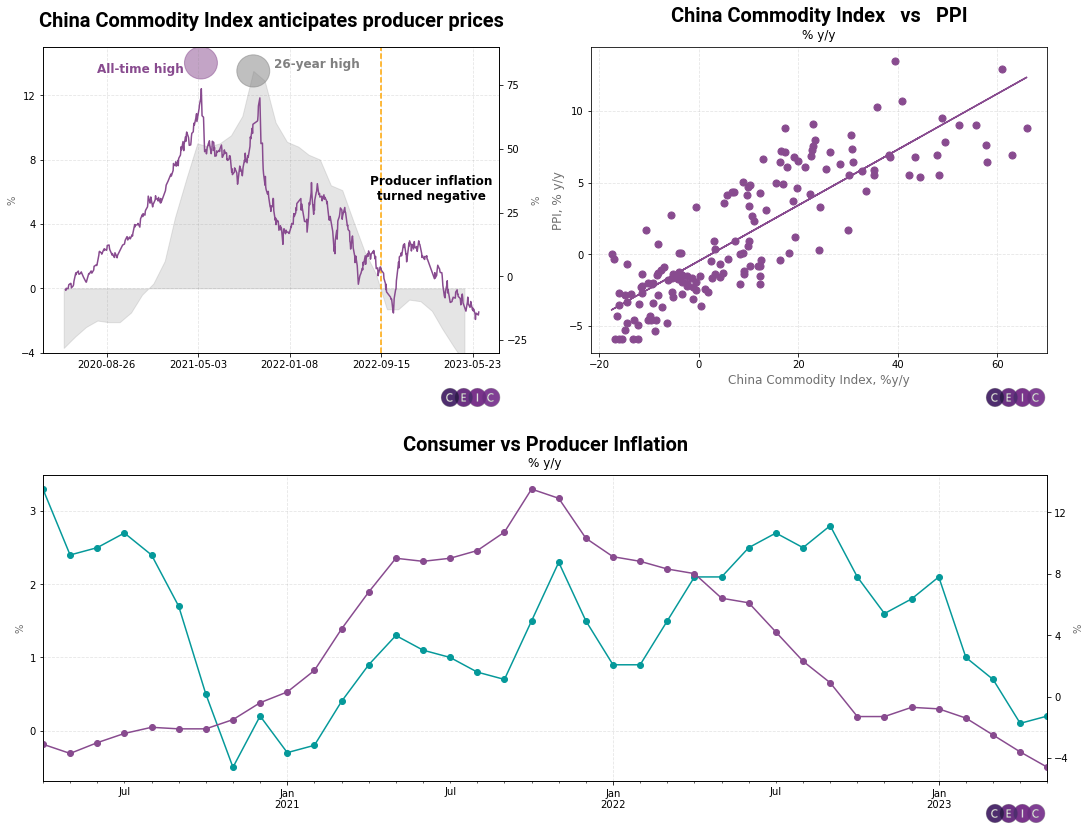

In [5]:
plot_chart()